## Batch Normalisation

### Learning Objectives
- Formula behind batch normalisation
- Application in PyTorch
- Advantage of batch normalisation

### Prerequisites
- Data normalisation
- Feed-forward neural networks
- Convolutional neural networks

### Intro
Before training a machine learning algorithm, it is common practice to normalise the input data, especially when the features have different scales, e.g. house prices and building year. This can lead to features with higher values having an unwanted greater impact on changes of a predictor. Normalising data can avoid this and lead to better performance. Since this technique is proven to work for the input data, it is natural to apply the same technique to the hidden layers in a neural network. <br>
Batch normalisation tackles the problem of internal covariate shift in deep neural networks, which describes the phenomenon that the input distribution of each layer changes a lot as the input to each layer is affected by the parameters of all preceding layers s.t. even small changes in parameters have a big impact on the parameters further down the line. Solving this problem typically requires careful initialisation of the parameters as well as small learning rates.

### Mathematical Notation
Batch normalisation basically sets the mean of each feature to zero and the variance to 1:
\begin{equation*}
\hat{x} = \frac{x - \mu(x)}{\sqrt{\sigma^2(x)}}
\end{equation*}
where the mean and variance are computed over the batch during training and over the population after training.<br>
The normalised features are then scaled and shifted by introducing the parameters $\gamma$ and $\beta$:
\begin{equation*}
y = \gamma \hat{x} + \beta
\end{equation*}
These steps are applied to the activations of each layer before feeding them as input to the next layer. Therefore, we must also include them in the backpropagation, which we do by calculating the gradient w.r.t. the new parameters $\gamma$ and $\beta$. 
These parameters are important because the computation of $\hat{x}$ where the mean is set to 0 with unit variance might not be desirable in every layer. Especially if we compute this for the input of a softmax function, it is desirable that the input has higher variance such that the output is a conclusive probability distribution over its input. The $\gamma$ and $\beta$ parameters learn to regulate $\hat{x}$. If $\gamma$ is set to $\sqrt{\sigma^2(x)}$ and $\beta$ is set to $\mu(x)$, we can restore the original values of $x$.
<br><br>

In a convolutional neural network, the normalisation is applied jointly over all locations in a feature map, s.t. we can learn the parameters $\gamma$ and $\beta$ per feature map and not per activation because we want to normalise the features in the same way regardless of whether they are in different convolutional windows. This means that we normalise the same activations in the same feature maps.  

### Implementation
We will use the CNN for MNIST image prediction that you already worked with before. Run the original code so you can compare performance to the same CNN using batch normalisation!

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


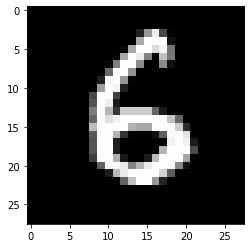

In [73]:
%load_ext tensorboard
import torch
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.tensorboard import SummaryWriter

# GET THE TRAINING DATASET
train_data = datasets.MNIST(root='MNIST-data',                        # where is the data (going to be) stored
                            transform=transforms.ToTensor(),          # transform the data from a PIL image to a tensor
                            train=True,                               # is this training data?
                            download=True                             # should i download it if it's not already here?
                           )

# GET THE TEST DATASET
test_data = datasets.MNIST(root='MNIST-data',
                           transform=transforms.ToTensor(),
                           train=False,
                          )

x = train_data[np.random.randint(0, 300)][0]    # get a random example
#print(x)
plt.imshow(x[0].numpy(),cmap='gray')
plt.show()

# FURTHER SPLIT THE TRAINING INTO TRAINING AND VALIDATION
train_data, val_data = torch.utils.data.random_split(train_data, [50000, 10000])    # split into 50K training & 10K validation

batch_size = 128

# MAKE TRAINING DATALOADER
train_loader = torch.utils.data.DataLoader(
    train_data,
    shuffle=True,
    batch_size=batch_size
)

# MAKE VALIDATION DATALOADER
val_loader = torch.utils.data.DataLoader(
    val_data,
    shuffle=True,
    batch_size=batch_size
)

# MAKE TEST DATALOADER
test_loader = torch.utils.data.DataLoader(
    test_data,
    shuffle=True,
    batch_size=batch_size
)

In [74]:
import torch.nn.functional as F

class ConvNet(torch.nn.Module):
    def __init__(self, batch_norm):
        super().__init__()
            # conv2d(in_channels, out_channels, kernel_size)
            # in_channels is the number of layers which it takes in (i.e.num color channels in 1st layer)
            # out_channels is the number of different filters that we use
            # kernel_size is the depthxwidthxheight of the kernel#
            # stride is how many pixels we shift the kernel by each time
        self.batch_norm = batch_norm
        if self.batch_norm:
            print('yes')
            self.conv_layers = torch.nn.Sequential( # put your convolutional architecture here using torch.nn.Sequential 
            torch.nn.Conv2d(1, 16, kernel_size=5, stride=1),
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(16),
            torch.nn.Conv2d(16, 32, kernel_size=5, stride=1),
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(32)
            )
            self.fc_layers = torch.nn.Sequential(
            torch.nn.Linear(32*20*20, 10) # put your linear architecture here using torch.nn.Sequential 
        )
        else:
            self.conv_layers = torch.nn.Sequential( # put your convolutional architecture here using torch.nn.Sequential 
            torch.nn.Conv2d(1, 16, kernel_size=5, stride=1),
            torch.nn.ReLU(),
            torch.nn.Conv2d(16, 32, kernel_size=5, stride=1),
            torch.nn.ReLU()
            )
            self.fc_layers = torch.nn.Sequential(
                torch.nn.Linear(32*20*20, 10) # put your linear architecture here using torch.nn.Sequential 
            )
    def forward(self, x):
        x = self.conv_layers(x)# pass through conv layers
        x = x.view(x.shape[0], -1)# flatten output ready for fully connected layer
        x = self.fc_layers(x)# pass through fully connected layer
        x = F.softmax(x, dim=1)# softmax activation function on outputs
        return x

In [80]:
use_cuda = torch.cuda.is_available() # checks if gpu is available
device = torch.device("cuda" if use_cuda else "cpu")
learning_rate = 0.0005 # set learning rate
epochs = 5 # set number of epochs

cnn = ConvNet(batch_norm=False).to(device) #.to(device)#instantiate model
criterion = torch.nn.CrossEntropyLoss() #use cross entropy loss function
optimiser = torch.optim.Adam(cnn.parameters(), lr=learning_rate) # use Adam optimizer, passing it the parameters of your model and the learning rate

# SET UP TRAINING VISUALISATION
writer1 = SummaryWriter(log_dir="runs/cnn") # we will use this to show our models performance on a graph

In [81]:
def train(model, epochs, writer, verbose=True, tag='Loss/Train'):
    for epoch in range(epochs):
        for idx, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            # pass x through your model to get a prediction
            prediction = model(inputs)             # pass the data forward through the model
            loss = criterion(prediction, labels)   # compute the cost
            if verbose: print('Epoch:', epoch, '\tBatch:', idx, '\tLoss:', loss.item())
            optimiser.zero_grad()                  # reset the gradients attribute of all of the model's params to zero
            loss.backward()                        # backward pass to compute and store all of the model's param's gradients
            optimiser.step()                       # update the model's parameters
            
            writer.add_scalar(tag, loss, epoch*len(train_loader) + idx)    # write loss to a graph
    print('Training Complete. Final loss =',loss.item())
    
train(cnn, epochs, writer=writer1)

05005
Epoch: 3 	Batch: 353 	Loss: 1.4823527336120605
Epoch: 3 	Batch: 354 	Loss: 1.4692952632904053
Epoch: 3 	Batch: 355 	Loss: 1.4763778448104858
Epoch: 3 	Batch: 356 	Loss: 1.5029478073120117
Epoch: 3 	Batch: 357 	Loss: 1.482025146484375
Epoch: 3 	Batch: 358 	Loss: 1.4939398765563965
Epoch: 3 	Batch: 359 	Loss: 1.5119682550430298
Epoch: 3 	Batch: 360 	Loss: 1.4724559783935547
Epoch: 3 	Batch: 361 	Loss: 1.4951804876327515
Epoch: 3 	Batch: 362 	Loss: 1.470774531364441
Epoch: 3 	Batch: 363 	Loss: 1.4798011779785156
Epoch: 3 	Batch: 364 	Loss: 1.479568362236023
Epoch: 3 	Batch: 365 	Loss: 1.5032215118408203
Epoch: 3 	Batch: 366 	Loss: 1.500737190246582
Epoch: 3 	Batch: 367 	Loss: 1.4723504781723022
Epoch: 3 	Batch: 368 	Loss: 1.494850516319275
Epoch: 3 	Batch: 369 	Loss: 1.4782570600509644
Epoch: 3 	Batch: 370 	Loss: 1.4615105390548706
Epoch: 3 	Batch: 371 	Loss: 1.5110297203063965
Epoch: 3 	Batch: 372 	Loss: 1.4826791286468506
Epoch: 3 	Batch: 373 	Loss: 1.4728959798812866
Epoch: 3 	Ba

In [82]:
import numpy as np
            
def calc_accuracy(model, dataloader):
    num_correct = 0
    num_examples = len(dataloader.dataset)                       # test DATA not test LOADER
    for inputs, labels in dataloader:                  # for all exampls, over all mini-batches in the test dataset
        predictions = model(inputs)
        predictions = torch.max(predictions, axis=1)    # reduce to find max indices along direction which column varies
        predictions = predictions[1]                    # torch.max returns (values, indices)
        num_correct += int(sum(predictions == labels))
    percent_correct = num_correct / num_examples * 100
    return percent_correct

print('Train Accuracy:', calc_accuracy(cnn, train_loader))
print('Validation Accuracy:', calc_accuracy(cnn, val_loader))
print('Test Accuracy:', calc_accuracy(cnn, test_loader))

Train Accuracy: 98.652
Validation Accuracy: 98.19
Test Accuracy: 98.31


### Exercise
Compare to cnn without batch normalisation <br>
Use a larger lr with batch normalisation
Add plots to show stability and fast convergence

In [84]:
#Set argument batch_norm to True
cnn2 = ConvNet(batch_norm=True).to(device)
optimiser = torch.optim.Adam(cnn2.parameters(), lr=learning_rate)
writer2 = SummaryWriter(log_dir="runs/cnn_bn_lr0005")
train(cnn2, epochs, writer=writer2)
print('Train Accuracy:', calc_accuracy(cnn2, train_loader))
print('Validation Accuracy:', calc_accuracy(cnn2, val_loader))
print('Test Accuracy:', calc_accuracy(cnn2, test_loader))

4 	Loss: 1.4690825939178467
Epoch: 3 	Batch: 355 	Loss: 1.504518985748291
Epoch: 3 	Batch: 356 	Loss: 1.473148226737976
Epoch: 3 	Batch: 357 	Loss: 1.4720790386199951
Epoch: 3 	Batch: 358 	Loss: 1.4752596616744995
Epoch: 3 	Batch: 359 	Loss: 1.462831735610962
Epoch: 3 	Batch: 360 	Loss: 1.4618823528289795
Epoch: 3 	Batch: 361 	Loss: 1.5017436742782593
Epoch: 3 	Batch: 362 	Loss: 1.4638078212738037
Epoch: 3 	Batch: 363 	Loss: 1.4766042232513428
Epoch: 3 	Batch: 364 	Loss: 1.462192177772522
Epoch: 3 	Batch: 365 	Loss: 1.4612401723861694
Epoch: 3 	Batch: 366 	Loss: 1.4644782543182373
Epoch: 3 	Batch: 367 	Loss: 1.4747031927108765
Epoch: 3 	Batch: 368 	Loss: 1.4773313999176025
Epoch: 3 	Batch: 369 	Loss: 1.4613133668899536
Epoch: 3 	Batch: 370 	Loss: 1.46896231174469
Epoch: 3 	Batch: 371 	Loss: 1.4839258193969727
Epoch: 3 	Batch: 372 	Loss: 1.4717891216278076
Epoch: 3 	Batch: 373 	Loss: 1.4728102684020996
Epoch: 3 	Batch: 374 	Loss: 1.4613990783691406
Epoch: 3 	Batch: 375 	Loss: 1.46645617

From the plot in tensorboard, you should see that the convergence happens a lot earlier. The model therefore seems to be more robust from the beginning. Next, you can try using a higher learing rate. 

In [83]:
#Try a larger learning rate
cnn3 = ConvNet(batch_norm=True).to(device)
optimiser = torch.optim.Adam(cnn3.parameters(), lr=0.05) #before lr=0.0005
writer3 = SummaryWriter(log_dir="runs/cnn_bn_lr05")
train(cnn2, epochs, writer=writer3)
print('Train Accuracy:', calc_accuracy(cnn2, train_loader))
print('Validation Accuracy:', calc_accuracy(cnn2, val_loader))
print('Test Accuracy:', calc_accuracy(cnn2, test_loader))

: 1.4697396755218506
Epoch: 3 	Batch: 355 	Loss: 1.4726462364196777
Epoch: 3 	Batch: 356 	Loss: 1.4646005630493164
Epoch: 3 	Batch: 357 	Loss: 1.4698542356491089
Epoch: 3 	Batch: 358 	Loss: 1.4690487384796143
Epoch: 3 	Batch: 359 	Loss: 1.4615857601165771
Epoch: 3 	Batch: 360 	Loss: 1.4766308069229126
Epoch: 3 	Batch: 361 	Loss: 1.4773776531219482
Epoch: 3 	Batch: 362 	Loss: 1.4771806001663208
Epoch: 3 	Batch: 363 	Loss: 1.4713208675384521
Epoch: 3 	Batch: 364 	Loss: 1.46147620677948
Epoch: 3 	Batch: 365 	Loss: 1.4868123531341553
Epoch: 3 	Batch: 366 	Loss: 1.465869426727295
Epoch: 3 	Batch: 367 	Loss: 1.486151099205017
Epoch: 3 	Batch: 368 	Loss: 1.4854943752288818
Epoch: 3 	Batch: 369 	Loss: 1.469657301902771
Epoch: 3 	Batch: 370 	Loss: 1.4883553981781006
Epoch: 3 	Batch: 371 	Loss: 1.476812481880188
Epoch: 3 	Batch: 372 	Loss: 1.4651477336883545
Epoch: 3 	Batch: 373 	Loss: 1.4831621646881104
Epoch: 3 	Batch: 374 	Loss: 1.474079966545105
Epoch: 3 	Batch: 375 	Loss: 1.4694504737854004

![Loss Comparison](images/loss.png)
From the three runs, we can see that the vanilla CNN (orange) took the longest to converge. The CNN with batch normalisation (red) was much faster to do so and we were even able to use a larger learning rate (blue), which leads to even faster convergence, because we have a more robust cnn due to batch normalisation.

### Summary
With batch normalisation, we can use larger learning rates and have to be less careful with the selection of initial parameters, which leads to faster convergence and better performance. The networks do not even need to be trained so long, hence we could introduce early stopping now. If you want to learn about early stopping, you can do so [here](https://www.kaggle.com/akhileshrai/tutorial-early-stopping-vanilla-rnn-pytorch). Batch normalisation even works as a regularisation technique. By estimating the mean and variance for each batch, we add noise to the input data of each following layer, which helps the regularisation capability of the network. <br>
It should be used with caution in combination with small batch sizes as the estimation of the mean and variance per batch is unstable, if we only have a small batch sample to calculate these values from.
